In [6]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
from google.colab import drive

ImportError: DLL load failed while importing _errors: Le module spécifié est introuvable.

In [ ]:
drive.mount('/content/drive')
data_path = '/content/drive/MyDrive/ISMIN/PE/STUDENT_BEL_signalprocessing/Correlation_stress_datasets'

Mounted at /content/drive


In [ ]:
files1 = h5py.File(data_path + '/1st_stress.h5', 'r')
data_raw = files1['00:07:80:0F:80:1A']['raw']

In [ ]:
def collectData(i):
    data_ecg, data_eda, data_rr, data_acc = [], [],[],[]
    data_ecg.append(data_raw['channel_1'][:i])
    data_eda.append(data_raw['channel_2'][:i])
    data_rr.append(data_raw['channel_3'][:i])
    data_acc.append(data_raw['channel_4'][:i])
    return [data_ecg, data_eda, data_rr, data_acc]

In [ ]:
def plotData(data):
    i = 1
    label = ['ECG', 'EDA', 'RR', 'ACC']
    fig = plt.figure(figsize=(60,20))
    print(data)
    for e in data:
        plt.subplot(2,2,i)
        plt.plot(e[0])
        plt.title(f'Raw {label[i-1]} Acquisition')
        plt.xlabel('Acquistition')
        plt.ylabel(f'{label[i-1]} Value')
        plt.legend()
        i += 1
    plt.show()

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


[[array([[32784],
       [32804],
       [32829],
       ...,
       [32788],
       [32772],
       [32741]], dtype=uint32)], [array([[872],
       [836],
       [870],
       ...,
       [866],
       [917],
       [867]], dtype=uint32)], [array([[26920],
       [27033],
       [26740],
       ...,
       [31108],
       [30990],
       [31102]], dtype=uint32)], [array([[34016],
       [34010],
       [33999],
       ...,
       [33716],
       [33724],
       [33732]], dtype=uint32)]]


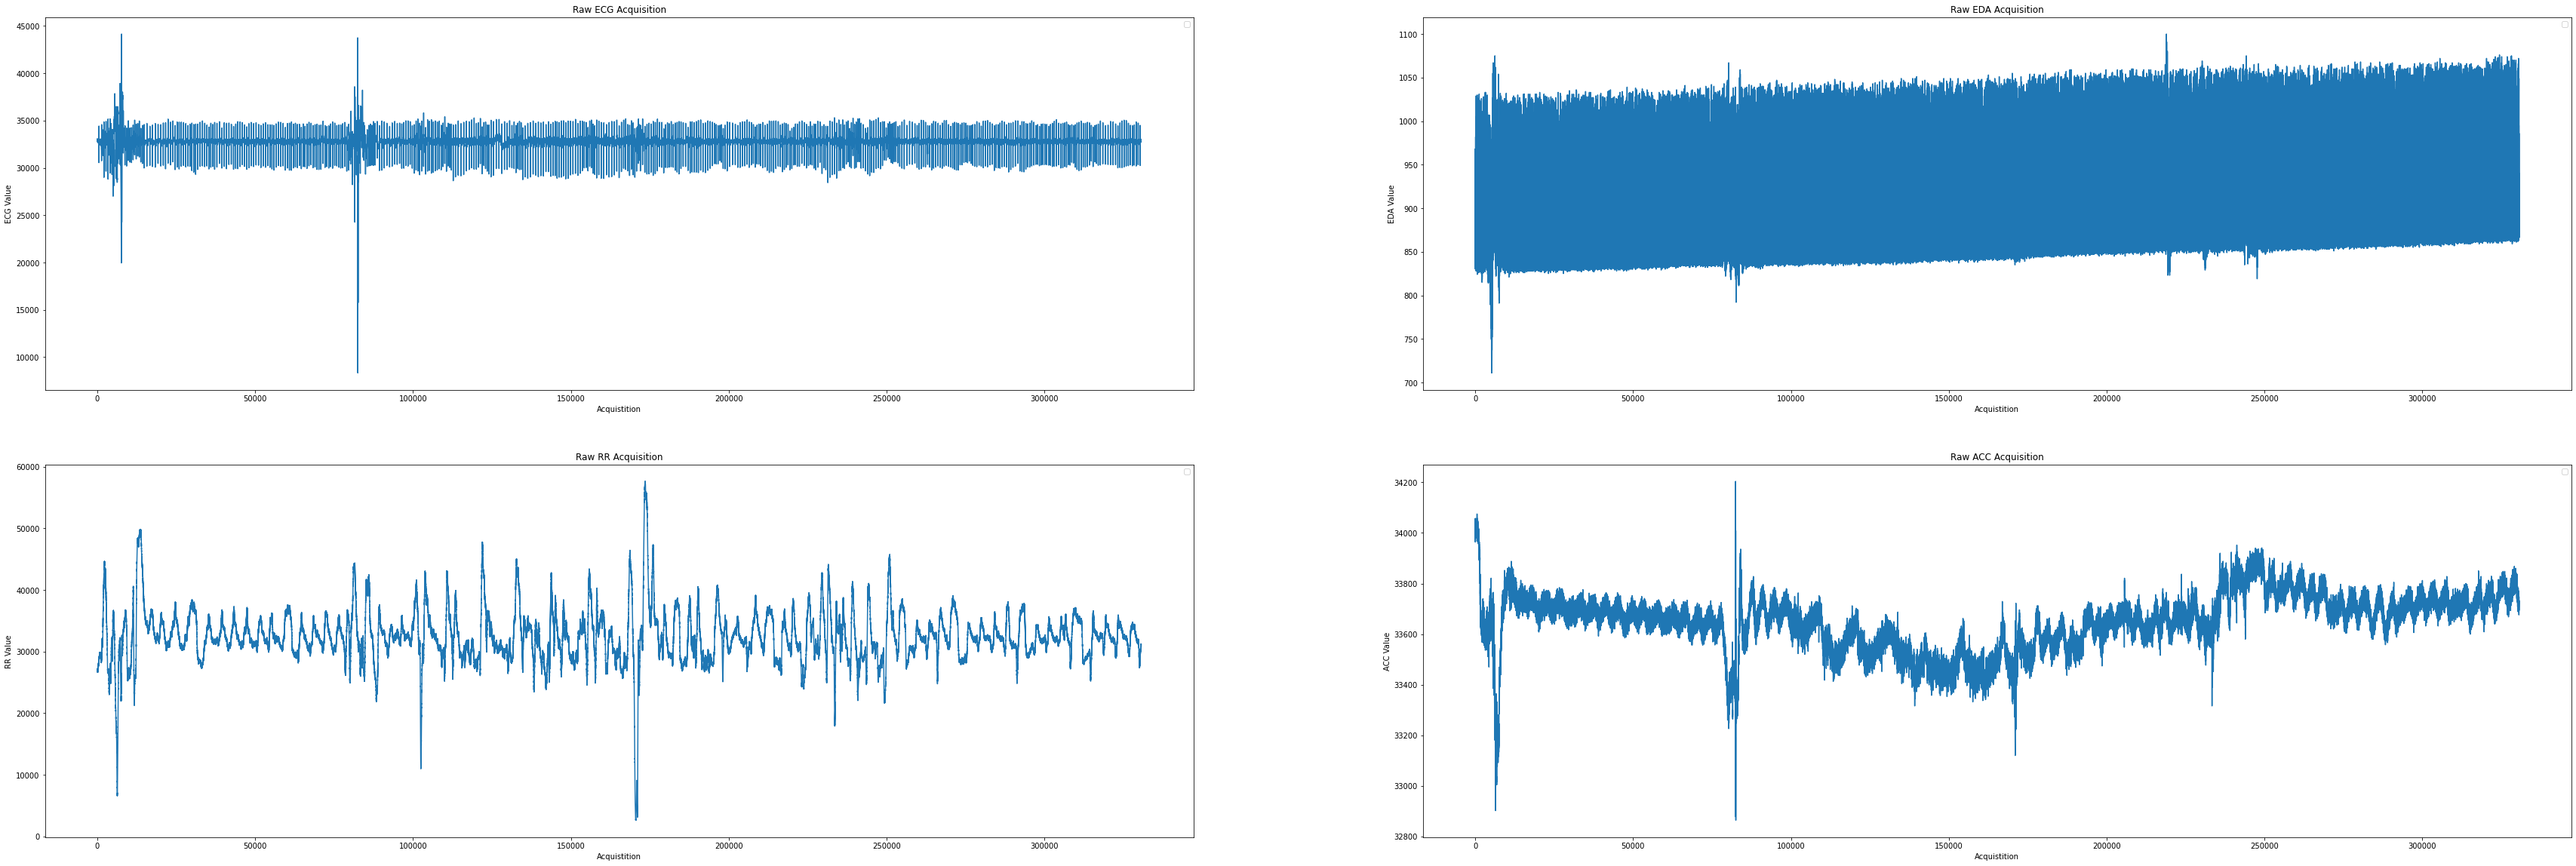

In [ ]:
full_data = collectData(-1)
plotData(full_data)

# Removing artefacts
https://www.youtube.com/watch?v=t-twhNqgfSY

In [1]:
!pip install mne

Defaulting to user installation because normal site-packages is not writeable
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [2]:
import numpy as np

import mne
from mne.datasets import sample

from mne.preprocessing import ICA
from mne.preprocessing import create_eog_epochs, create_ecg_epochs

Setting up data:

In [5]:
# load data
raw_fname = './Correlation_stress_datasets/1st_stress.edf'
raw = mne.io.read_raw_edf(raw_fname, preload=True)

# 1Hz high pass is often helpful for fitting ICA
raw.filter(1., 40., n_jobs=2, fir_design='firwin')

picks_eeg = mne.pick_types(raw.info, eeg=True)

Extracting EDF parameters from c:\Users\guill\Documents\ISMIN\Semestre 10\PE\PE_BMD\Correlation_stress_datasets\1st_stress.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 330999  =      0.000 ...   330.999 secs...


ImportError: DLL load failed while importing _ufuncs: Le module spécifié est introuvable.

In [ ]:
print(picks_eeg)
print(raw)
print(raw.info)

[0 1 2 3]
<RawEDF | 1st_stress.edf, 4 x 331000 (331.0 s), ~10.1 MB, data loaded>
<Info | 7 non-empty values
 bads: []
 ch_names: EGG, EDA, RESPIRATION, XYZ
 chs: 4 EEG
 custom_ref_applied: False
 highpass: 1.0 Hz
 lowpass: 40.0 Hz
 meas_date: 2020-12-14 12:53:59 UTC
 nchan: 4
 projs: []
 sfreq: 1000.0 Hz
>


Fit ICA:

In [ ]:
n_components = 4  # if float, select n_components by explained variance of PCA
method = 'fastica'  # for comparison with EEGLAB try "extended-infomax" here
decim = 3  # we need sufficient statistics, not all time points -> saves time

# we will also set state of the random number generator - ICA is a
# non-deterministic algorithm, but we want to have the same decomposition
# and the same order of components each time this tutorial is run
random_state = 3

ica = ICA(n_components=n_components, method=method, random_state=random_state)
print(ica)

<ICA | no decomposition, fit (fastica):  samples, no dimension reduction>


In [ ]:
reject = dict(mag=5e-12, grad=4000e-13)
ica.fit(raw, picks=picks_eeg, decim=decim, reject=reject)
print(ica)

Fitting ICA to data using 4 channels (please be patient, this may take a while)
Selecting by number: 4 components
Fitting ICA took 0.5s.
<ICA | raw data decomposition, fit (fastica): 110055 samples, 4 components, channels used: "eeg">


<ipython-input-71-d181768292b2>:2: RuntimeWarning: Using n_components=4 (resulting in n_components_=4) may lead to an unstable mixing matrix estimation because the ratio between the largest (4) and smallest (1.8e-08) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 3
  ica.fit(raw, picks=picks_meg, decim=decim, reject=reject)


Applying ICA to Raw instance
    Transforming to ICA space (4 components)
    Zeroing out 0 ICA components
    Projecting back using 4 PCA components


/usr/local/lib/python3.7/dist-packages/matplotlib/colors.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  c = np.array(c)


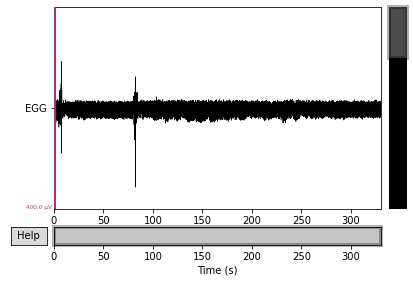

/usr/local/lib/python3.7/dist-packages/matplotlib/colors.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  c = np.array(c)


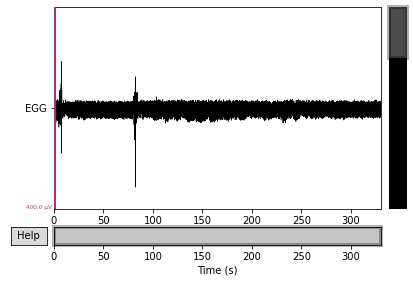

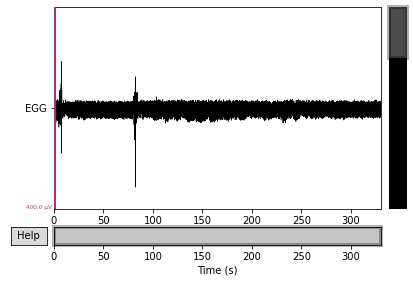

In [ ]:
# check the result
ica.apply(raw).plot(n_channels=1, duration=1000, scalings=dict(eeg=20e-5))  
raw.plot(n_channels=1, duration=1000, scalings=dict(eeg=20e-5))

#ica.apply(raw).plot_psd(average=True) #power spectral density